In [3]:
from pandas import DataFrame, read_csv;

import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

car_prices = pd.read_csv('/Users/tkapil/Learning/CarPrice_Assignment.csv')

#############derive the company name##############

car_prices["company_name"] = car_prices.CarName.str.split(" ").str.get(0)

#### Rename the cars which does not have proper names
car_prices.loc[car_prices["company_name"] == "toyouta", "company_name"] = "toyota"
car_prices.loc[car_prices["company_name"] == "porcshce", "company_name"] = "porsche"
car_prices.loc[car_prices["company_name"] == "vokswagen", "company_name"] = "volkswagen"
car_prices.loc[car_prices["company_name"] == "vw", "company_name"] = "volkswagen"
car_prices.loc[car_prices["company_name"] == "maxda", "company_name"] = "mazda"
car_prices.loc[car_prices["enginetype"] == "dohcv", "enginetype"] = "dohc"


car_prices["company_name"] = car_prices["company_name"].str.upper();

###########binary categorical variables
car_prices['fueltype'] = car_prices['fueltype'].map({'gas': 1, 'diesel': 0})
car_prices['aspiration'] = car_prices['aspiration'].map({'std': 1, 'turbo': 0})
car_prices['doornumber'] = car_prices['doornumber'].map({'two': 2, 'four': 4})
car_prices['enginelocation'] = car_prices['enginelocation'].map({'front': 1, 'rear': 0})

car_prices.drop(['car_ID'],axis=1,inplace=True)
car_prices.drop(['CarName'],axis=1,inplace=True)


#######create dummy variable for carbody column ##########

## If all are zero, then it means that its convertible
car_body_dummies = pd.get_dummies(car_prices['carbody'], drop_first=True)
car_prices = pd.concat([car_prices,car_body_dummies],axis=1)
car_prices.drop(['carbody'],axis=1,inplace=True)

#######create dummy variable for drivewheel column ##########

## If all are zero, then it means that its 4wd
car_drive_wheels = pd.get_dummies(car_prices['drivewheel'], drop_first=True)
car_prices = pd.concat([car_prices,car_drive_wheels],axis=1)
car_prices.drop(['drivewheel'],axis=1,inplace=True)


#######create dummy variable for enginetype column ##########

## If all are zero, then it means that its dohc
car_enginetypes = pd.get_dummies(car_prices['enginetype'], drop_first=True)
car_prices = pd.concat([car_prices,car_enginetypes],axis=1)
car_prices.drop(['enginetype'],axis=1,inplace=True)


#######create dummy variable for cylindernumber column ##########

## If all are zero, then it means that its eight
car_cylindernumber = pd.get_dummies(car_prices['cylindernumber'], drop_first=True)
car_prices = pd.concat([car_prices,car_cylindernumber],axis=1)
car_prices.drop(['cylindernumber'],axis=1,inplace=True)


#######create dummy variable for fuelsystem column ##########

## If all are zero, then it means that its 1bbl
car_fuelsystem = pd.get_dummies(car_prices['fuelsystem'], drop_first=True)
car_prices = pd.concat([car_prices,car_fuelsystem] ,axis=1)
car_prices.drop(['fuelsystem'],axis=1,inplace=True)

#######create dummy variable for company_name column ##########

## If all are zero, then it means that its ALFA-ROMERO
car_company_name = pd.get_dummies(car_prices['company_name'], drop_first=True)
car_prices = pd.concat([car_prices,car_company_name] ,axis=1)
car_prices.drop(['company_name'],axis=1,inplace=True)

print(car_prices.head())

def normalize (x):
    return ((x-np.mean(x))/(max(x) - min(x)))

car_prices = car_prices.apply(normalize)

y = car_prices['price']

X = car_prices[['symboling', 'fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg', 'hardtop', 'hatchback', 'sedan', 'wagon', 'fwd', 'rwd', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor', 'five',
       'four', 'six', 'three', 'twelve', 'two', '2bbl', '4bbl', 'idi','mfi', 'mpfi', 'spdi', 'spfi', 'AUDI', 'BMW', 'BUICK',
       'CHEVROLET', 'DODGE', 'HONDA', 'ISUZU', 'JAGUAR', 'MAZDA','MERCURY', 'MITSUBISHI', 'NISSAN', 'PEUGEOT', 'PLYMOUTH',
       'PORSCHE', 'RENAULT', 'SAAB', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN','VOLVO']]

print(X.head())


#random_state is the seed used by the random number generator, it can be any integer.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

lm = LinearRegression()
rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

print(X_train.columns[rfe.support_])
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]


#function for calculating VIF
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)


## Basically here I have copy-pasted columns from rfe.support_ variable
final_car_prices = car_prices[['enginelocation', 'carwidth', 'curbweight', 'enginesize',
       'boreratio', 'stroke', 'rotor', 'five', 'four', 'three',
       'twelve', 'two', 'BMW', 'PEUGEOT', 'PORSCHE', 'price']]


   symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
0          3         1           1           2               1       88.6   
1          3         1           1           2               1       88.6   
2          1         1           1           2               1       94.5   
3          2         1           1           4               1       99.8   
4          2         1           1           4               1       99.4   

   carlength  carwidth  carheight  curbweight  ...    NISSAN  PEUGEOT  \
0      168.8      64.1       48.8        2548  ...         0        0   
1      168.8      64.1       48.8        2548  ...         0        0   
2      171.2      65.5       52.4        2823  ...         0        0   
3      176.6      66.2       54.3        2337  ...         0        0   
4      176.6      66.4       54.3        2824  ...         0        0   

   PLYMOUTH  PORSCHE  RENAULT  SAAB  SUBARU  TOYOTA  VOLKSWAGEN  VOLVO  
0         0        0     

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


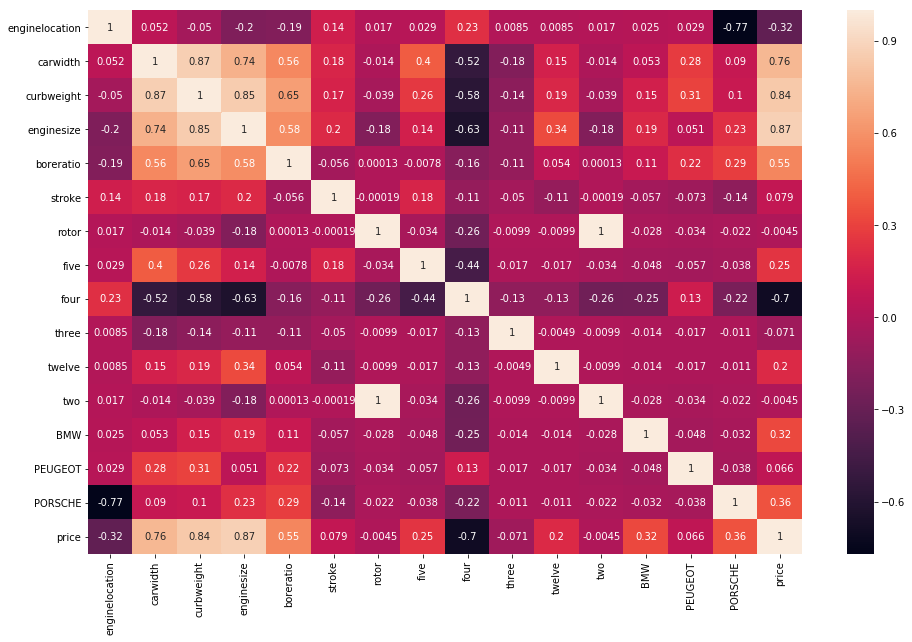

In [4]:
plt.figure(figsize = (16,10))     # Size of the figure
sns.heatmap(final_car_prices.corr(), annot = True)

In [5]:

###########################Model 1#################
X_train_rfe = sm.add_constant(X_train_rfe)

lm1 = sm.OLS(y_train, X_train_rfe).fit()

print(lm1.summary())

print(vif_cal(input_data=final_car_prices, dependent_col="price"))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     141.8
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           1.03e-70
Time:                        02:46:48   Log-Likelihood:                 232.74
No. Observations:                 143   AIC:                            -435.5
Df Residuals:                     128   BIC:                            -391.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0047      0.004      1.

/usr/local/Cellar/ipython@5/5.6.0/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in double_scalars


In [6]:
###########################Model 2 ################
X_train_rfe = X_train_rfe.drop(['two'], axis=1)

lm2 = sm.OLS(y_train, X_train_rfe).fit()

print(lm2.summary())

print(vif_cal(input_data=final_car_prices.drop(["two"], axis=1), dependent_col="price"))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     141.8
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           1.03e-70
Time:                        02:46:56   Log-Likelihood:                 232.74
No. Observations:                 143   AIC:                            -435.5
Df Residuals:                     128   BIC:                            -391.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0047      0.004      1.

In [7]:
###########################Model 3 ################
X_train_rfe = X_train_rfe.drop('enginesize', 1)

lm3= sm.OLS(y_train, X_train_rfe).fit()

print(lm3.summary())

print(vif_cal(input_data=final_car_prices.drop(["enginesize", "two"], axis=1), dependent_col="price"))


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           5.01e-61
Time:                        02:47:02   Log-Likelihood:                 205.02
No. Observations:                 143   AIC:                            -382.0
Df Residuals:                     129   BIC:                            -340.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0005      0.005      0.

In [8]:
###########################Model 4 ################
X_train_rfe = X_train_rfe.drop('four', 1)

lm4= sm.OLS(y_train, X_train_rfe).fit()

print(lm4.summary())

print(vif_cal(input_data=final_car_prices.drop(["enginesize", "two", 'four'], axis=1), dependent_col="price"))


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     110.5
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           4.72e-62
Time:                        02:47:10   Log-Likelihood:                 205.00
No. Observations:                 143   AIC:                            -384.0
Df Residuals:                     130   BIC:                            -345.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0006      0.005      0.

In [9]:
###########################Model 5 ################

X_train_rfe = X_train_rfe.drop('five', 1)

lm5= sm.OLS(y_train, X_train_rfe).fit()

print(lm5.summary())

print(vif_cal(input_data=final_car_prices.drop(['five',"enginesize", "two", 'four'], axis=1), dependent_col="price"))


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     121.4
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           4.37e-63
Time:                        02:47:53   Log-Likelihood:                 204.95
No. Observations:                 143   AIC:                            -385.9
Df Residuals:                     131   BIC:                            -350.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0005      0.005      0.

In [10]:
###########################Model 6 ################

X_train_rfe = X_train_rfe.drop('stroke', 1)

lm6= sm.OLS(y_train, X_train_rfe).fit()

print(lm6.summary())

print(vif_cal(input_data=final_car_prices.drop(['five',"enginesize", "two", 'four', 'stroke'], axis=1), dependent_col="price"))


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     134.0
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           4.72e-64
Time:                        02:50:26   Log-Likelihood:                 204.68
No. Observations:                 143   AIC:                            -387.4
Df Residuals:                     132   BIC:                            -354.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0006      0.005      0.